In [1]:
import numpy as np
from pathlib import Path
import pandas as pd
from sys import platform
import os
import matplotlib.pyplot as plt
import seaborn as sns
from utils import *
from scipy.signal import medfilt
from scipy.stats import sem, ranksums, ttest_ind
%matplotlib inline
%load_ext autoreload
%autoreload 2
sns.set(font_scale=2, style='ticks')

In [2]:
vol_file = Path('../Analysis/depreciated/analysis_sections_gain.csv')
dat_xls_file = pd.read_csv(vol_file, index_col=0)
dat_xls_file['folder'] = dat_xls_file['folder'].apply(lambda x: f'{x:0>8}')

In [3]:
t_pre = 100 # time window pre-swim
t_post = 350 # time window post-swim
t_label = np.arange(-t_pre, t_post)/300
t_sig = 240
k_ = gaussKernel(sigma=1)
ave_low_list = []
ave_low_list_ = []
ave_high_list = []
p_mat = []
fish_id = []

for ind, row in dat_xls_file.iterrows():    
    folder = row['folder']
    fish = row['fish']
    task_type = row['task']
    
    _ = np.load(f'../Analysis/swim_power/{folder}_{fish}_swim_dat.npz')
    task_period = _['task_period'] 
    swim_starts = _['swim_starts'] 
    trial_valid = np.ones(len(swim_starts)).astype('bool')
    r_swim = _['r_swim']
    l_swim = _['l_swim']
    visu = _['visu']
    task_period = _['task_period']
    swim_task_index = _['swim_task_index']
    p_swim = np.sqrt(r_swim**2+l_swim**2)
    
    for n, n_swim in enumerate(swim_starts[:-1]):        
        # examine the swim with short inter-swim-interval
        if swim_starts[n+1] - n_swim < t_sig:    
            trial_valid[n] = False
    
    p_ave = p_swim[:, :(t_pre+t_sig)].sum(axis=-1)
    p_ave_thres = np.percentile(p_ave[(task_period==2) & trial_valid], 85)
    
    low_ind = (task_period==1) & trial_valid & (p_ave<p_ave_thres)
    low_ind_ = (task_period==1) & trial_valid 
    high_ind = (task_period==2) & trial_valid
    
    if (low_ind).sum()<30:
        continue
    gain_stat = np.zeros(t_pre+t_sig)
    for ntime in range(-t_pre, t_sig):
        val, pval= ttest_ind(p_swim[low_ind, t_pre+ntime], 
                            p_swim[high_ind, t_pre+ntime])
        gain_stat[t_pre+ntime] = np.sign(-val) * pval
        gain_stat[np.isnan(gain_stat)] = 1.0
    if (np.abs(gain_stat)<0.05).sum()>20:
        continue
    
#     plt.figure(figsize=(4, 3))
#     plt.plot(t_label, p_swim[low_ind, :].mean(axis=0), '-k')
#     plt.plot(t_label, p_swim[high_ind, :].mean(axis=0), '-r')
#     plt.ylabel('Swim power')
#     plt.xlabel('Time (sec)')
#     plt.xlim([-0.2, 0.8])
#     sns.despine()
#     plt.savefig(f'../Plots/gain/exp_neuron_swim_{folder+fish[:5]}_motor_clamp.pdf')
    
#     plt.figure(figsize=(4, 3))
#     plt.plot(t_label, visu[low_ind, :].mean(axis=0), '-k')
#     plt.plot(t_label, visu[high_ind, :].mean(axis=0), '-r')
#     plt.ylabel('Vel')
#     plt.xlabel('Time (sec)')
#     plt.xlim([-0.2, 0.8])
#     sns.despine()
#     plt.savefig(f'../Plots/gain/exp_neuron_Vel_{folder+fish[:5]}_motor_clamp.pdf')
    
    _ = np.load(f'../Analysis/swim_voltr/{folder}_{fish}_swim_voltr_dat.npz')
    # trial_valid = _['trial_valid']
    sub_swim = _['sub_swim']
    spk_swim = _['spk_swim']
    
    for n_cell in range(sub_swim.shape[0]):
        spk_list = spk_swim[n_cell]
        tmp = []
        for n_spk in spk_list:
            tmp.append(smooth(n_spk, k_))
        spk_list = np.array(tmp)
        
        non_trial = np.isnan(spk_list).sum(axis=-1)==0
        
        gain_stat = np.zeros(t_pre+t_post)
        for ntime in range(-t_pre, t_post):
            val, pval= ranksums(spk_list[low_ind_ & non_trial, t_pre+ntime], 
                                spk_list[high_ind & non_trial, t_pre+ntime])
            gain_stat[ntime] = np.sign(-val) * pval
        p_mat.append(gain_stat)
        ave_low_list_.append(spk_list[low_ind_ & non_trial].mean(axis=0)*300)
        ave_low_list.append(spk_list[low_ind & non_trial].mean(axis=0)*300)
        ave_high_list.append(spk_list[high_ind & non_trial].mean(axis=0)*300)
        fish_id.append(folder+fish[:5])

# print number of fish
len(np.unique(np.array(fish_id)))

3

In [4]:
# ave_act = np.array(ave_low_list).mean(axis=0)
# sem_act = np.array(ave_low_list).std(axis=0)/np.sqrt(len(ave_low_list))

# plt.figure(figsize=(8, 3))
# plt.plot(t_label, ave_act, '-k', lw=2)
# plt.plot(t_label, ave_act+sem_act, '--k', lw=0.5)
# plt.plot(t_label, ave_act-sem_act, '--k', lw=0.5)

# ave_act = np.array(ave_high_list).mean(axis=0)
# sem_act = np.array(ave_high_list).std(axis=0)/np.sqrt(len(ave_high_list))
# plt.plot(t_label, ave_act, '-r', lw=2)
# plt.plot(t_label, ave_act+sem_act, '--r', lw=0.5)
# plt.plot(t_label, ave_act-sem_act, '--r', lw=0.5)

# plt.vlines([0], [0], [1.0], linestyles='--', colors='k')
# plt.xlim([-60/300, 330/300])
# plt.ylim([0, 0.7])
# plt.yticks(np.arange(0, 1.0, 0.5))
# plt.xticks([0, 1])
# plt.xlabel('Time from swim bout (sec)')
# plt.ylabel('Spikes (/sec)')
# sns.despine()
# # plt.savefig('../Plots/gain/pop_act_ave.pdf')

19


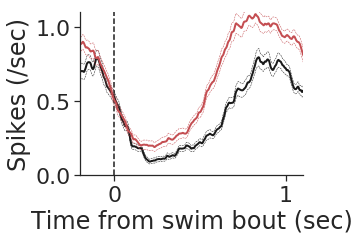

In [5]:
sig_mat = np.abs(p_mat)[:, t_pre-30:(t_pre+300)]<0.05
sel_ind = sig_mat.sum(axis=-1)>30
ave_act = np.array(ave_low_list)[sel_ind].mean(axis=0)
sem_act = np.array(ave_low_list)[sel_ind].std(axis=0)/np.sqrt(len(ave_low_list))
print(sel_ind.sum())

plt.figure(figsize=(4, 3))
plt.plot(t_label, ave_act, '-k', lw=2)
plt.plot(t_label, ave_act+sem_act, '--k', lw=0.5)
plt.plot(t_label, ave_act-sem_act, '--k', lw=0.5)

ave_act = np.array(ave_high_list)[sel_ind].mean(axis=0)
sem_act = np.array(ave_high_list)[sel_ind].std(axis=0)/np.sqrt(len(ave_high_list))
plt.plot(t_label, ave_act, '-r', lw=2)
plt.plot(t_label, ave_act+sem_act, '--r', lw=0.5)
plt.plot(t_label, ave_act-sem_act, '--r', lw=0.5)

plt.vlines([0], [0], [1.1], linestyles='--', colors='k')
plt.xlim([-60/300, 330/300])
plt.ylim([0, 1.1])
plt.yticks(np.arange(0, 1.01, 0.5))
plt.xticks([0, 1])
plt.xlabel('Time from swim bout (sec)')
plt.ylabel('Spikes (/sec)')
sns.despine()
# plt.savefig('../Plots/gain/pop_sel_act_motor_control_ave_org.pdf')

19


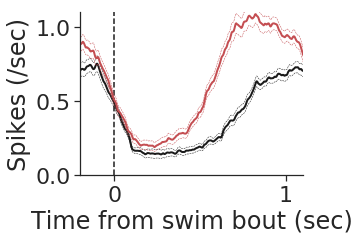

In [6]:
sig_mat = np.abs(p_mat)[:, t_pre-30:(t_pre+300)]<0.05
sel_ind = sig_mat.sum(axis=-1)>30
ave_act = np.array(ave_low_list_)[sel_ind].mean(axis=0)
sem_act = np.array(ave_low_list_)[sel_ind].std(axis=0)/np.sqrt(len(ave_low_list))
print(sel_ind.sum())

plt.figure(figsize=(4, 3))
plt.plot(t_label, ave_act, '-k', lw=2)
plt.plot(t_label, ave_act+sem_act, '--k', lw=0.5)
plt.plot(t_label, ave_act-sem_act, '--k', lw=0.5)

ave_act = np.array(ave_high_list)[sel_ind].mean(axis=0)
sem_act = np.array(ave_high_list)[sel_ind].std(axis=0)/np.sqrt(len(ave_high_list))
plt.plot(t_label, ave_act, '-r', lw=2)
plt.plot(t_label, ave_act+sem_act, '--r', lw=0.5)
plt.plot(t_label, ave_act-sem_act, '--r', lw=0.5)

plt.vlines([0], [0], [1.1], linestyles='--', colors='k')
plt.xlim([-60/300, 330/300])
plt.ylim([0, 1.1])
plt.yticks(np.arange(0, 1.01, 0.5))
plt.xticks([0, 1])
plt.xlabel('Time from swim bout (sec)')
plt.ylabel('Spikes (/sec)')
sns.despine()
# plt.savefig('../Plots/gain/pop_sel_act_motor_control_ave_after.pdf')